<a href="https://colab.research.google.com/github/worldone-web/Team4-Traveler/blob/main/bpr_with_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!whoami

root


In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


일반적으로 사용자가 관측된 데이터는 1로 표시, 관측하지 않은 데이터를 0으로 표시하여
데이터셋을 구성하고 훈련을 진행하면 대부분의 원소들은 훈련동안 학습 알고리즘에서
Negative 피드백으로 나타남. -> 해당방식은 사용자가 좋아할지도 모르는 아이템에 대해 부정적인 피드백으로 나타냄.

---

훈련 데이터를 정확히 적합시킬 수 있는 모델도 0만 예측하기 때문에, 더 이상 랭크를 매길 수 없다. -> 그러나 해당 데이터로
랭킹을 예측할 수 있는 이유는 Regularization 같이, 오버피팅을 예방할수 있는 방법이 존재해서 예측가능

---

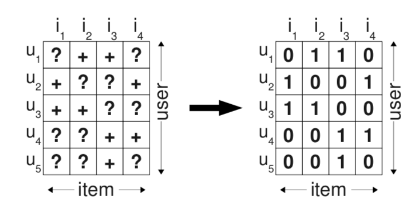


위와 같은 문제를 해결하기 위해 아이템 pair를
훈련데이터로 사용하는 접근법을 사용한다.


---

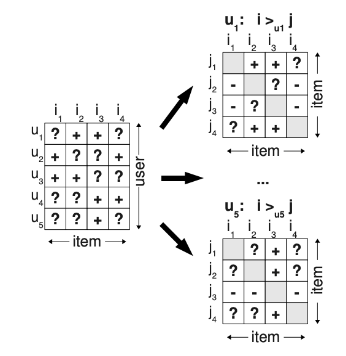



해당 접근법을 사용하는 이유는 결측치를 Negative값으로 대체하는 것보다 문제를 더 잘 표현한다.

---

예를 들어 유저 u가 아이템 i를 조회했다면, 우리는 조회하지 않은 다른 모든 아이템보다
아이템 i를 더 선호한다고 가정한다.


---

위의 접근법에는 3가지 조건이 존재한다.
1. 조회한 아이템은 조회하지 않은 아이템보다 더 선호된다.
2. 조회된 두 가지 아이템의 경우, 어떤 선호도도 추론하지 않는다.
3. 조회되지 않은 두 가지 아이템의 경우,
어떤 선호도도 추론하지 않는다.



위와 같이 ranking을 기반으로 한 방식은 다음과 같은 특성이 존재한다.

---
1. 관측되지 않은 item에도 정보를 부여해 간접적으로 학습시킬 수 있도록 한다. (기존 방식처럼 모두 0으로 간주하는 것보다 나은 결과를 줌)

2. 관측되지 않은 item들에 대해서도 순서를 메길 수 있다. 즉 기존 방식은 모두 0으로 예측되어 순서를 메길 수 없었던 것과 달리, ranking을 학습함으로써 이를 추론할 수 있도록 한다.

위의 조건을 통해 공식화하면 다음과 같이 훈련 데이터를 구성할 수 있다.

In [ ]:
import pandas as pd
import random

# CSV 파일 읽기
df = pd.read_csv("/content/drive/MyDrive/BPR/new_philadelphia_checkin_filtered.csv")

# 사용자, 음식점 데이터 추출
user_ids = df['newUserId'].astype('category').cat.codes #카테고리형 테이터 타입 변환 및 카테고리의 코드 반환(정수코드)
item_ids = df['newBusinessId'].astype('category').cat.codes

# 사용자가 방문한 음식점 집합 생성
users_visited_items = {}
for user_id, item_id in zip(user_ids, item_ids):
    if user_id not in users_visited_items:
        users_visited_items[user_id] = set() # 초기에 사용자에 대한 음식점 집합 만들기
    users_visited_items[user_id].add(item_id) # 각 사용자에 대해 방문한 음식점 추가

# Pairwise preference 계산을 위한 데이터 생성
train_data = []
for user_id, visited_items in users_visited_items.items():
    # 방문하지 않은 음식점 집합 생성
    unvisited_items = list(set(item_ids.unique()) - visited_items)
    # 각 사용자당 100개의 방문하지 않은 음식점을 무작위로 선택
    unvisited_items = random.sample(unvisited_items, min(100, len(unvisited_items)))
    for item_id_i in visited_items: # 방문한 음식점을 선호
        for item_id_j in unvisited_items: # 방문하지 않은 음식점을 비선호
            train_data.append((user_id, item_id_i, item_id_j)) # (사용자, 선호, 비선호)


In [ ]:
print(train_data[:1000])

[(0, 0, 5577), (0, 0, 4761), (0, 0, 4702), (0, 0, 2745), (0, 0, 4470), (0, 0, 6633), (0, 0, 5672), (0, 0, 6701), (0, 0, 2358), (0, 0, 5495), (0, 0, 3924), (0, 0, 6110), (0, 0, 5026), (0, 0, 4146), (0, 0, 6469), (0, 0, 598), (0, 0, 1337), (0, 0, 4496), (0, 0, 2527), (0, 0, 4300), (0, 0, 5841), (0, 0, 2663), (0, 0, 6843), (0, 0, 4707), (0, 0, 1444), (0, 0, 117), (0, 0, 3702), (0, 0, 1031), (0, 0, 4920), (0, 0, 1524), (0, 0, 397), (0, 0, 4698), (0, 0, 3804), (0, 0, 6971), (0, 0, 3153), (0, 0, 4460), (0, 0, 5302), (0, 0, 6117), (0, 0, 4876), (0, 0, 4816), (0, 0, 839), (0, 0, 5763), (0, 0, 5793), (0, 0, 434), (0, 0, 5188), (0, 0, 4925), (0, 0, 6684), (0, 0, 6934), (0, 0, 2068), (0, 0, 3445), (0, 0, 817), (0, 0, 5907), (0, 0, 6664), (0, 0, 6793), (0, 0, 3317), (0, 0, 6683), (0, 0, 3784), (0, 0, 1482), (0, 0, 4405), (0, 0, 514), (0, 0, 624), (0, 0, 1251), (0, 0, 5925), (0, 0, 3733), (0, 0, 6530), (0, 0, 6481), (0, 0, 5337), (0, 0, 6989), (0, 0, 1896), (0, 0, 3121), (0, 0, 151), (0, 0, 75), (0

위의 정의한 학습데이터 D(s)를 이용하여 Bayesian Personalized Raking을 구하는 방법


---

일반적으로 Bayesian optimization이란, 사후확률을 최대화 하는 파라미터 Θ를 찾는 것이다. 이를 최대 사후 확률 추정이라고 한다. '사후확률'이란 어떤 정보가 고려된 파라미터에 대한 확률이다. 여기서는 user의 선호정보 (>u)가 된다.

---

요약하면 (u>) 정보가 주어지면, 이를 최대한  잘 나타낼 수 있는 파라미터를 추정한는 것이다. 사후확률은 베이즈 정리에 의해 likelihood와 사전확률의 곱으로 나타낼 수 있으며, 먼저 likelihood에 대해서 다음과 같이 표현할 수 있다.

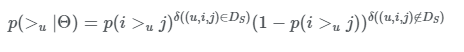

위의 식을 정리하기 위해 user가 item i보다 j를 선호할 확률인 p(i >u j)를 정의해야한다. 여기서는 X(uij)의 sigmoid값으로 정의된다. X(uij)을 구하기 위해서 Matrix Factorization을 사용한다. 즉 likelihood는 sigmoid함수를 통해서 값을 구한다.

---

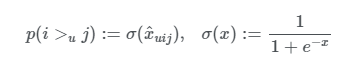

다음으로는 사전확률이다. 사전확률은 파라미터 Θ에 대한 확률 분포를 가정하는것이다. 여기서는 normal을 사용했다.

---

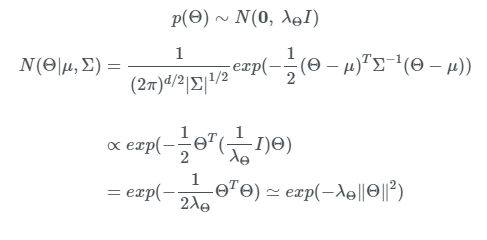


likelihood와 사전확률을 정의했다면, 이제 사후확률을 최대화 하는 Θ를 구할 차례다. Θ는 다음과 같이 정의된다.

---

Θ= {P(u),Q(i)} (여기서 P(u),Q(i)는 각각 user,item latent vector)
이를 식으로 표현하면 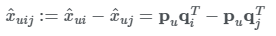 와 같이 정의된다.

MF는 user와 item의 latent vector를 예측하는 것이므로 P(u), Q(i)가 파라미티가 된다. user와 item i, item j간의 관계인 X(uij)는 user의 item i에 대한 점수인 X(ui)와, item j에 대한 점수인 X(uj)의 차이로 정의된다.

---

해당 값은 양수이며 차이가 클수록 P(i >u j) := σ(X(uij))가 1에 가까워진다. 즉, likelihood(sigmoid), 사전확률(잠재요인행렬), MF의 예측방법을 이용하여 파라미터 Θ를 구한다.

파라미터 Θ를 업데이트 하는 방법으로 gradient descent를 사용하여 다음과 같이 각 파라미터에 대한 gradient를 업데이트를 한다.



---

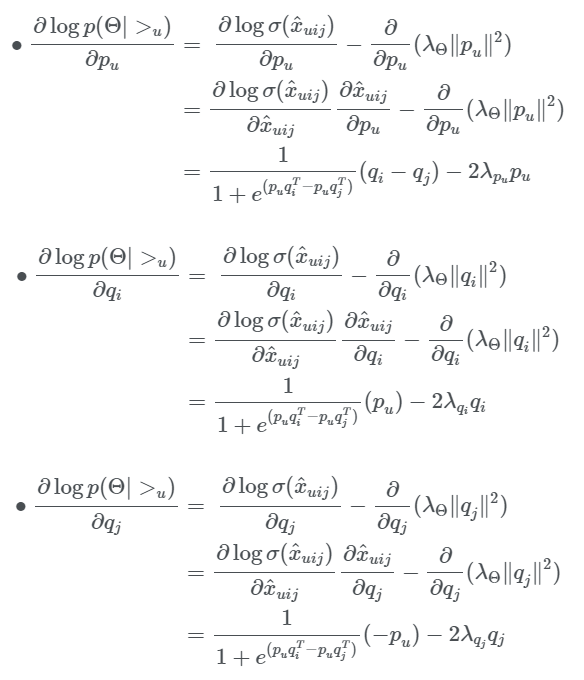

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

class BPR:
    def __init__(self, num_users, num_items, num_factors=10, learning_rate=0.01, reg_lambda=0.01):
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = num_factors #잠재적 요인의 차원 수
        self.learning_rate = learning_rate # 학습률
        self.reg_lambda = reg_lambda # 정규화 가중치 - 과적합 방지용 - 작을수록 과적합 up, 클수록 학습방해 up

        # 잠재 요인 행렬
        self.user_factors = np.random.normal(scale=1./num_factors, size=(num_users, num_factors)) # 유저, 잠재적 요인 행렬
        self.item_factors = np.random.normal(scale=1./num_factors, size=(num_items, num_factors)) # 음식점, 잠재적 요인 행렬
        # scale = 1./num_factors 는 정규 분포에서 샘플을 생성할 때 사용되는 표준편차
        # num_factors가 클수록 표준편차가 작아지므로 요소의 값이 평균 주변에 가까워짐 -> 과적합 위험
        # num_factors가 작을수록 표준편차가 커지므로 요소의 값이 평균 주변에서 멀어짐 -> 성능은 별로지만 일반화 성능이 향상


    def fit(self, train_data, num_epochs=10):
        for epoch in range(num_epochs):
            for user_id, item_id_i, item_id_j in train_data:
                # 주어진 사용자, 음식점에 대해 해당하는 잠재요인 가져오기
                user_factor = self.user_factors[user_id]
                item_factor_i = self.item_factors[item_id_i]
                item_factor_j = self.item_factors[item_id_j]

                # 잠재 요인의 차이를 계산
                diff = np.dot(user_factor, item_factor_i - item_factor_j)
                # 잠재요인의 차이를 이용하여 업데이트 방향성(gradient) 조절
                gradient = np.exp(-diff) / (1 + np.exp(-diff)) #logistic function을 사용하여 차이가 클수록 순서가 불명확해짐.
                #gradient = 1 / (1 + np.exp(-diff))  #<ipython-input-4-8da0ee917d4d>:29: RuntimeWarning: overflow encountered in exp gradient = 1 / (1 + np.exp(-diff))

                # 사용자, 음식점i,j의 파라미터 Θ업데이트
                self.user_factors[user_id] += self.learning_rate * (gradient * (item_factor_i - item_factor_j) - self.reg_lambda * user_factor)
                self.item_factors[item_id_i] += self.learning_rate * (gradient * user_factor - self.reg_lambda * item_factor_i)
                self.item_factors[item_id_j] += self.learning_rate * (-gradient * user_factor - self.reg_lambda * item_factor_j)

    def predict(self, user_id, item_id):
        return np.dot(self.user_factors[user_id], self.item_factors[item_id])

# 사용자 및 음식점 수 계산
num_users = len(user_ids.unique())
num_items = len(item_ids.unique())


# 데이터셋을 학습용(train)과 테스트용(test)으로 분리 (예: 학습 데이터 80%, 테스트 데이터 20%)
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

# BPR 모델 초기화 및 학습
bpr_model = BPR(num_users, num_items)
bpr_model.fit(train_data)




정리하면 likelihood와 사전확률의 곱셉하여 사용자 u가 아이템 j보다 i를 선호할 확률을 구한뒤 해당 선호할 확률을 최적화 시켜주는 SGD 방식을 통해 최적의 Θ를 구하는 방식으로 학습이 진행된다.

In [ ]:
def precision_at_k(model, user_ids, item_ids, k):
    precision_sum = 0.0
    total_users = 0

    for user_id in user_ids.unique():  # 모든 유저에 대해서 반복
        # 각 사용자에 대한 음식점의 예측값 계산
        user_predictions = [(item_id, model.predict(user_id, item_id)) for item_id in item_ids.unique()]
        # 예측값을 기준으로 상위 K개의 아이템 선택
        user_predictions.sort(key=lambda x: x[1], reverse=True) # 두번째 요소를 기준으로 내림차순
        top_k_items = [item_id for item_id, _ in user_predictions[:k]]

        # 사용자가 실제로 선호하는 아이템과 추천된 상위 K개의 아이템을 비교하여 Precision 계산
        user_visited_items = set(item_ids[user_ids == user_id])

        # 교집합을 이용하여 사용자의 선호하는 음식점과 추천한 음식점의 중복된 음식점결과를 생성
        correct_predictions = len(set(top_k_items) & user_visited_items)
        precision = correct_predictions / k

        precision_sum += precision
        total_users += 1

    # 전체 사용자에 대한 Precision의 평균을 계산하여 반환
    return precision_sum / total_users

# 예시: 상위 10개의 아이템을 추천하여 Precision at 10 계산
precision_at_10 = precision_at_k(bpr_model, user_ids, item_ids, k=10)
print("Precision at 10:", precision_at_10)


Precision at 10: 0.09975957552644807


In [ ]:
def precision_at_k(model, test_data, k=10):
    precisions = []
    for user_id, _, _ in test_data:
        # 사용자가 선호하는 아이템들 가져오기
        user_items = users_visited_items[user_id]
        # 사용자가 선호하는 아이템을 제외한 모든 아이템에 대한 예측 점수 계산
        all_items = list(set(item_ids.unique()) - user_items)
        scores = [(item_id, model.predict(user_id, item_id)) for item_id in all_items]
        # 점수에 따라 내림차순 정렬
        scores.sort(key=lambda x: x[1], reverse=True)
        # 상위 k개 아이템 추출
        top_k_items = [item_id for item_id, _ in scores[:k]]
        # 교집합을 이용하여 사용자의 선호하는 음식점과 추천한 음식점의 중복된 음식점결과를 생성
        num_hits = len(set(top_k_items) & user_items)
        # Precision@k 계산
        precision = num_hits / k
        precisions.append(precision)
    # 전체 사용자들에 대한 Precision@k 평균 계산
    return np.mean(precisions)

# 테스트 데이터 생성 (예시로 학습 데이터의 10%를 사용)
test_data = random.sample(train_data, int(len(train_data) * 0.1))

# precision_at_k 계산
precision = precision_at_k(bpr_model, test_data)
print("Precision@k:", precision)


사용자당 미방문 음식점 쌍 1000


In [ ]:
import pandas as pd
import random

# CSV 파일 읽기
df = pd.read_csv("/content/drive/MyDrive/BPR/new_philadelphia_checkin_filtered.csv")

# 사용자, 음식점 데이터 추출
user_ids = df['newUserId'].astype('category').cat.codes
item_ids = df['newBusinessId'].astype('category').cat.codes

# 사용자가 방문한 음식점 집합 생성
users_visited_items = {}
for user_id, item_id in zip(user_ids, item_ids):
    if user_id not in users_visited_items:
        users_visited_items[user_id] = set()
    users_visited_items[user_id].add(item_id)

# Pairwise preference 계산을 위한 데이터 생성
train_data = []
for user_id, visited_items in users_visited_items.items():
    # 방문하지 않은 음식점 집합 생성
    unvisited_items = list(set(item_ids.unique()) - visited_items)
    # 각 사용자당 1000개의 방문하지 않은 음식점을 무작위로 선택
    unvisited_items = random.sample(unvisited_items, min(1000, len(unvisited_items)))
    for item_id_i in visited_items:
        for item_id_j in unvisited_items:
            train_data.append((user_id, item_id_i, item_id_j))


In [ ]:
import numpy as np
import pandas as pd

class BPR:
    def __init__(self, num_users, num_items, num_factors=10, learning_rate=0.01, reg_lambda=0.01):
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = num_factors
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda

        self.user_factors = np.random.normal(scale=1./num_factors, size=(num_users, num_factors))
        self.item_factors = np.random.normal(scale=1./num_factors, size=(num_items, num_factors))

    def fit(self, train_data, num_epochs=1):
        for epoch in range(num_epochs):
            for user_id, item_id_i, item_id_j in train_data:
                user_factor = self.user_factors[user_id]
                item_factor_i = self.item_factors[item_id_i]
                item_factor_j = self.item_factors[item_id_j]


                diff = np.dot(user_factor, item_factor_i - item_factor_j)
                gradient = np.exp(-diff) / (1 + np.exp(-diff))


                self.user_factors[user_id] += self.learning_rate * (gradient * (item_factor_i - item_factor_j) - self.reg_lambda * user_factor)
                self.item_factors[item_id_i] += self.learning_rate * (gradient * user_factor - self.reg_lambda * item_factor_i)
                self.item_factors[item_id_j] += self.learning_rate * (-gradient * user_factor - self.reg_lambda * item_factor_j)

    def predict(self, user_id, item_id):
        return np.dot(self.user_factors[user_id], self.item_factors[item_id])

# 사용자 및 음식점 수 계산
num_users = len(user_ids.unique())
num_items = len(item_ids.unique())

# BPR 모델 초기화 및 학습
bpr_model = BPR(num_users, num_items)
bpr_model.fit(train_data)


In [ ]:
def precision_at_k(model, user_ids, item_ids, k):
    precision_sum = 0.0
    total_users = 0

    for user_id in user_ids.unique():  # 모든 유저에 대해서 반복
        # 각 사용자에 대한 음식점의 예측값 계산
        user_predictions = [(item_id, model.predict(user_id, item_id)) for item_id in item_ids.unique()]
        # 예측값을 기준으로 상위 K개의 아이템 선택
        user_predictions.sort(key=lambda x: x[1], reverse=True) # 두번째 요소를 기준으로 내림차순
        top_k_items = [item_id for item_id, _ in user_predictions[:k]]

        # 사용자가 실제로 선호하는 아이템과 추천된 상위 K개의 아이템을 비교하여 Precision 계산
        user_visited_items = set(item_ids[user_ids == user_id])

        # 교집합을 이용하여 사용자의 선호하는 음식점과 추천한 음식점의 중복된 음식점결과를 생성
        correct_predictions = len(set(top_k_items) & user_visited_items)
        precision = correct_predictions / k

        precision_sum += precision
        total_users += 1

    # 전체 사용자에 대한 Precision의 평균을 계산하여 반환
    return precision_sum / total_users

# 예시: 상위 10개의 아이템을 추천하여 Precision at 10 계산
precision_at_10 = precision_at_k(bpr_model, user_ids, item_ids, k=10)
print("Precision at 10:", precision_at_10)


Precision at 10: 0.0481346377051919
